## Loading data

In [1]:
import numpy as np
import pandas as pd
import geoplotlib as gp
from scipy import stats
from collections import Counter
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder as LE

In [2]:
df = pd.read_csv("NYPD_Motor_Vehicle_Collisions_reduced_data.csv", low_memory=False)

In [3]:
# Drop NaN values from Lat and Lon
df = df.dropna(subset=['LATITUDE','LONGITUDE'])

In [4]:
df = df[(np.abs(stats.zscore(df[['LATITUDE','LONGITUDE']])) < 1).all(axis=1)]
df.shape

(802922, 37)

In [5]:
df.head()

,Date,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,Maximum Humidity,Mean Temperature,Min Temperature,Minimum Humidity,Precipitation,Sea Level Pressure,Snow,Snow Depth,Visibility,Wind Speed
0,2017/03/28,0:00,BRONX,10466,40.894600,-73.861206,"(40.8946, -73.861206)",NaN,0,0,...,100,7,5,89,18.29,1014.0,0.00,0.00,7.0,9
1,2017/03/28,0:00,BROOKLYN,11218,40.654080,-73.977610,"(40.65408, -73.97761)",18 STREET,0,0,...,100,7,5,89,18.29,1014.0,0.00,0.00,7.0,9
2,2017/03/28,0:00,BROOKLYN,11235,40.583847,-73.940590,"(40.583847, -73.94059)",NaN,0,0,...,100,7,5,89,18.29,1014.0,0.00,0.00,7.0,9
3,2017/03/28,0:00,MANHATTAN,10019,40.762770,-73.975590,"(40.76277, -73.97559)",NaN,0,0,...,100,7,5,89,18.29,1014.0,0.00,0.00,7.0,9
4,2017/03/28,0:00,QUEENS,11429,40.713715,-73.731440,"(40.713715, -73.73144)",222 STREET,0,0,...,100,7,5,89,18.29,1014.0,0.00,0.00,7.0,9


In [6]:
df.columns

Index(['Date', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'Average Humidity', 'Dew Point', 'Events',
       'Max Gust Speed', 'Max Temperature', 'Max Wind Speed',
       'Maximum Humidity', 'Mean Temperature', 'Min Temperature',
       'Minimum Humidity', 'Precipitation', 'Sea Level Pressure', 'Snow',
       'Snow Depth', 'Visibility', 'Wind Speed'],
      dtype='object')

## Preprocessing data for modelling

First, model time as an hour of the day.

In [7]:
df['TIME'] = df['TIME'].apply(lambda x: int(x.split(':')[0]))

In [8]:
np.unique(df['TIME'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

Next, create a new column for months only.

In [9]:
df['Month'] = df['Date'].apply(lambda x: int(x.split('/')[1]))

In [10]:
np.unique(df['Month'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Next, we use label encoder to numerically encode boroughs in NYC.

In [11]:
Counter(df['BOROUGH'])

Counter({nan: 93407,
         'BRONX': 92414,
         'MANHATTAN': 183018,
         'BROOKLYN': 217596,
         'QUEENS': 183414,
         'STATEN ISLAND': 33073})

Since there are some missing values - we have to deal with them. In this case, the missing borough values are replaced with 'UNKNOWN'.

In [12]:
df['BOROUGH'] = df['BOROUGH'].fillna(value='UNKNOWN')

Now the boroughs can be encoded with one-hot encoding and added to the dataframe for modelling. 

In [13]:
df_BR_dummies = pd.get_dummies(df['BOROUGH'])
df_BR_dummies.head()

,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,UNKNOWN
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,1,0,0


Add the one-hot encoded columns to the dataframe.

In [14]:
df = df.join(df_BR_dummies)
df.head()

,Date,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,Snow Depth,Visibility,Wind Speed,Month,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,UNKNOWN
0,2017/03/28,0,BRONX,10466,40.894600,-73.861206,"(40.8946, -73.861206)",NaN,0,0,...,0.00,7.0,9,3,1,0,0,0,0,0
1,2017/03/28,0,BROOKLYN,11218,40.654080,-73.977610,"(40.65408, -73.97761)",18 STREET,0,0,...,0.00,7.0,9,3,0,1,0,0,0,0
2,2017/03/28,0,BROOKLYN,11235,40.583847,-73.940590,"(40.583847, -73.94059)",NaN,0,0,...,0.00,7.0,9,3,0,1,0,0,0,0
3,2017/03/28,0,MANHATTAN,10019,40.762770,-73.975590,"(40.76277, -73.97559)",NaN,0,0,...,0.00,7.0,9,3,0,0,1,0,0,0
4,2017/03/28,0,QUEENS,11429,40.713715,-73.731440,"(40.713715, -73.73144)",222 STREET,0,0,...,0.00,7.0,9,3,0,0,0,1,0,0


Next, vehicle types will be encoded with one hot as well.

In [15]:
Counter(df['VEHICLE TYPE CODE 1'])

Counter({nan: 3932,
         'PASSENGER VEHICLE': 456919,
         'FIRE TRUCK': 700,
         'SMALL COM VEH(4 TIRES) ': 12352,
         'UNKNOWN': 17859,
         'VAN': 22869,
         'LARGE COM VEH(6 OR MORE TIRES)': 11129,
         'BICYCLE': 1537,
         'TAXI': 33520,
         'MOTORCYCLE': 4406,
         'SCOOTER': 262,
         'BUS': 12317,
         'AMBULANCE': 2087,
         'PEDICAB': 25,
         'SPORT UTILITY / STATION WAGON': 181379,
         'OTHER': 20714,
         'PICK-UP TRUCK': 12611,
         'LIVERY VEHICLE': 8304})

We will NaN values with 'OTHER'.

In [16]:
df[['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2']] = df[['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2']].fillna('OTHER')

Before that is done, vehicles are grouped into 4 classes depending on their size:

In [17]:
name_dict = {
'two_wheeler': ['BICYCLE', 'PEDICAB', 'SCOOTER', 'MOTORCYCLE'],
'small': ['PASSENGER VEHICLE', 'TAXI'],
'medium': ['AMBULANCE', 'SPORT UTILITY / STATION WAGON', 'PICK-UP TRUCK', 'SMALL COM VEH(4 TIRES) ', 'LIVERY VEHICLE', 'VAN'],
'large': ['BUS', 'FIRE TRUCK', 'LARGE COM VEH(6 OR MORE TIRES)'],
'other': ['OTHER', 'UNKNOWN']}

And replace those values in the dictionary.

In [18]:
df_repl = df[['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2']].copy()

for new_name in name_dict:
    
    for old_name in name_dict[new_name]:
    
        df_repl = df_repl[['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2']].replace(to_replace=old_name, value=new_name)

Now we can apply one-hot endcoding to the vehicle type as well.

In [19]:
df_VT_dummies = pd.get_dummies(df_repl[['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2']], prefix=['VTC1', 'VTC2'])
df_VT_dummies.head()

,VTC1_large,VTC1_medium,VTC1_other,VTC1_small,VTC1_two_wheeler,VTC2_large,VTC2_medium,VTC2_other,VTC2_small,VTC2_two_wheeler
0,0,1,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0,1,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,1,0


And we join that to the dataframe as well.

In [20]:
df = df.join(df_VT_dummies)
df.head()

,Date,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,VTC1_large,VTC1_medium,VTC1_other,VTC1_small,VTC1_two_wheeler,VTC2_large,VTC2_medium,VTC2_other,VTC2_small,VTC2_two_wheeler
0,2017/03/28,0,BRONX,10466,40.894600,-73.861206,"(40.8946, -73.861206)",NaN,0,0,...,0,1,0,0,0,0,0,1,0,0
1,2017/03/28,0,BROOKLYN,11218,40.654080,-73.977610,"(40.65408, -73.97761)",18 STREET,0,0,...,0,0,0,1,0,0,0,1,0,0
2,2017/03/28,0,BROOKLYN,11235,40.583847,-73.940590,"(40.583847, -73.94059)",NaN,0,0,...,0,0,0,1,0,0,0,1,0,0
3,2017/03/28,0,MANHATTAN,10019,40.762770,-73.975590,"(40.76277, -73.97559)",NaN,0,0,...,0,1,0,0,0,0,0,1,0,0
4,2017/03/28,0,QUEENS,11429,40.713715,-73.731440,"(40.713715, -73.73144)",222 STREET,0,0,...,0,1,0,0,0,0,0,0,1,0


Lastly, we do one-hot encoding for events. First we start by replacing NaN with Other.

In [21]:
df['Events'] = df['Events'].fillna('Other')

In [22]:
np.unique(df['Events'])

array(['Fog', 'Fog\n\t,\nRain', 'Fog\n\t,\nRain\n\t,\nSnow',
       'Fog\n\t,\nSnow', 'Other', 'Rain', 'Rain\n\t,\nSnow', 'Snow'], dtype=object)

In [23]:
df_EV_dummies = pd.DataFrame(columns=['Rain', 'Snow', 'Fog', 'Other'], index=df.index)

In [24]:
for column in df_EV_dummies.columns:
    df_EV_dummies[column] = np.zeros(df.shape[0])

In [25]:
df_EV_dummies.head()

,Rain,Snow,Fog,Other
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [26]:
# loop through all rows in the dataframe
for index, row in enumerate(df['Events']):
    
    for event in row.split(','):
        
        event = event.strip()
        
        for c_idx, column in enumerate(['Rain', 'Snow', 'Fog', 'Other']):
            
            if event == column:
                df_EV_dummies.iloc[index, c_idx] = 1

In [27]:
# checking if the code worked
df_EV_dummies[df['Events'] == 'Fog\n\t,\nRain\n\t,\nSnow'].head()

,Rain,Snow,Fog,Other
230844,1.0,1.0,1.0,0.0
230845,1.0,1.0,1.0,0.0
230846,1.0,1.0,1.0,0.0
230847,1.0,1.0,1.0,0.0
230848,1.0,1.0,1.0,0.0


Rename columns because of same names in the main df, and remove the Other column as it does not provide valuable information.

In [28]:
df_EV_dummies.columns = ['Rain_EV', 'Snow_EV', 'Fog_EV', 'Other_EV']
df_EV_dummies = df_EV_dummies.drop('Other_EV', axis=1)

In [29]:
df_EV_dummies.head()

,Rain_EV,Snow_EV,Fog_EV
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


Now we can join the even and main dataframes.

In [30]:
df = df.join(df_EV_dummies)

In [31]:
df.head()

,Date,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,VTC1_small,VTC1_two_wheeler,VTC2_large,VTC2_medium,VTC2_other,VTC2_small,VTC2_two_wheeler,Rain_EV,Snow_EV,Fog_EV
0,2017/03/28,0,BRONX,10466,40.894600,-73.861206,"(40.8946, -73.861206)",NaN,0,0,...,0,0,0,0,1,0,0,1.0,0.0,0.0
1,2017/03/28,0,BROOKLYN,11218,40.654080,-73.977610,"(40.65408, -73.97761)",18 STREET,0,0,...,1,0,0,0,1,0,0,1.0,0.0,0.0
2,2017/03/28,0,BROOKLYN,11235,40.583847,-73.940590,"(40.583847, -73.94059)",NaN,0,0,...,1,0,0,0,1,0,0,1.0,0.0,0.0
3,2017/03/28,0,MANHATTAN,10019,40.762770,-73.975590,"(40.76277, -73.97559)",NaN,0,0,...,0,0,0,0,1,0,0,1.0,0.0,0.0
4,2017/03/28,0,QUEENS,11429,40.713715,-73.731440,"(40.713715, -73.73144)",222 STREET,0,0,...,0,0,0,0,0,1,0,1.0,0.0,0.0


We also model the contributing factor in vehicle one.

In [32]:
cont_to_keep = []

for i in Counter(df['CONTRIBUTING FACTOR VEHICLE 1']).most_common(16):
    cont_to_keep.append(i[0])

cont_to_keep.remove('Unspecified')
cont_to_keep

['Driver Inattention/Distraction',
 'Fatigued/Drowsy',
 'Failure to Yield Right-of-Way',
 'Other Vehicular',
 'Backing Unsafely',
 'Turning Improperly',
 'Lost Consciousness',
 'Prescription Medication',
 'Traffic Control Disregarded',
 'Driver Inexperience',
 'Following Too Closely',
 'Pavement Slippery',
 'Outside Car Distraction',
 'Physical Disability',
 'Alcohol Involvement']

In the end we have 338228 observations that had some contributing factor:

In [33]:
df[df['CONTRIBUTING FACTOR VEHICLE 1'].isin(cont_to_keep)].shape

(338228, 57)

In [34]:
df = df[df['CONTRIBUTING FACTOR VEHICLE 1'].isin(cont_to_keep)]

In [35]:
df_CNT_dummies = pd.get_dummies(df['CONTRIBUTING FACTOR VEHICLE 1'])
df_CNT_dummies.head()

,Alcohol Involvement,Backing Unsafely,Driver Inattention/Distraction,Driver Inexperience,Failure to Yield Right-of-Way,Fatigued/Drowsy,Following Too Closely,Lost Consciousness,Other Vehicular,Outside Car Distraction,Pavement Slippery,Physical Disability,Prescription Medication,Traffic Control Disregarded,Turning Improperly
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [36]:
df = df.join(df_CNT_dummies)
df.head()

,Date,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,Fatigued/Drowsy,Following Too Closely,Lost Consciousness,Other Vehicular,Outside Car Distraction,Pavement Slippery,Physical Disability,Prescription Medication,Traffic Control Disregarded,Turning Improperly
0,2017/03/28,0,BRONX,10466,40.894600,-73.861206,"(40.8946, -73.861206)",NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017/03/28,0,BROOKLYN,11235,40.583847,-73.940590,"(40.583847, -73.94059)",NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017/03/28,0,QUEENS,11429,40.713715,-73.731440,"(40.713715, -73.73144)",222 STREET,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2017/03/28,0,UNKNOWN,NaN,40.803585,-73.915520,"(40.803585, -73.91552)",NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2017/03/28,0,UNKNOWN,NaN,40.835194,-73.874054,"(40.835194, -73.874054)",NaN,0,0,...,0,1,0,0,0,0,0,0,0,0


Now we can select the relevant columns for modelling:

In [37]:
df.columns

Index(['Date', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'Average Humidity', 'Dew Point', 'Events',
       'Max Gust Speed', 'Max Temperature', 'Max Wind Speed',
       'Maximum Humidity', 'Mean Temperature', 'Min Temperature',
       'Minimum Humidity', 'Precipitation', 'Sea Level Pressure', 'Snow',
       'Snow Depth', 'Visibility', 'Wind Speed', 'Month', 'BRONX', 'BROOKLYN',
       'MANHATTAN', 'QUEENS', 'STATEN ISLAND', 'UNKNOWN', 'VTC1_large',
       'VTC1_medium', 'VTC1_other', 'VTC1_small', 'VTC1_two_wheeler',
       'VTC2_large',

In [38]:
df_ml = df.drop(['Date', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'Events'], axis=1)

In [39]:
df_ml.head(10)

,TIME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,Average Humidity,...,Fatigued/Drowsy,Following Too Closely,Lost Consciousness,Other Vehicular,Outside Car Distraction,Pavement Slippery,Physical Disability,Prescription Medication,Traffic Control Disregarded,Turning Improperly
0,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,95,...,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
13,10,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
16,10,1,0,1,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
18,10,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0


Now we need to add our y (any person injured or killed) to our dataframe.

In [40]:
df_ml['Y'] = np.zeros(df.shape[0])

In [41]:
def fill_Y(row):
    
    if np.any(row[['NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED']] > 0):
        return 1
    else:
        return 0

In [42]:
df_ml['Y'] = df_ml.apply(lambda x: fill_Y(x), axis=1)

In [43]:
df_ml.head(10)

,TIME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,Average Humidity,...,Following Too Closely,Lost Consciousness,Other Vehicular,Outside Car Distraction,Pavement Slippery,Physical Disability,Prescription Medication,Traffic Control Disregarded,Turning Improperly,Y
0,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,95,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
13,10,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0
16,10,1,0,1,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,1
18,10,0,0,0,0,0,0,0,0,95,...,0,0,0,0,0,0,0,0,0,0


There are some strange values in some of the rows still that should be numeric - for example in the 'Snow' column there are some rows with 'T' instead of snow depth. This also causes that column to be encoded as strings instead of numbers.

Therefore we need to cast the cells to numbers where we can.

In [44]:
Counter(df_ml['Snow']).most_common(5)

[('0.00', 307777), ('T', 14699), ('1.02', 1222), ('1.27', 1075), (nan, 983)]

Those that are encoded as strings:

- Max Gust Speed
- Max Wind Speed
- Precipitation
- Snow
- Snow Depth
- Wind Speed

In [45]:
df_ml.head()['Snow'][0]

'0.00'

In [46]:
def cast_to_float(x):
    
    try:
        return float(x)
        
    except Exception as error:
        return x

In [47]:
for column in ['Max Gust Speed', 'Max Wind Speed', 'Precipitation', 'Snow', 'Snow Depth', 'Wind Speed']:
    
    df_ml[column] = df_ml[column].apply(lambda x: cast_to_float(x))

Now we can see that they have been casted to float.

In [48]:
df_ml.head()['Snow'][0]

0.0

In [49]:
df_ml.head().applymap(np.isreal).all(1)

0    True
2    True
4    True
5    True
6    True
dtype: bool

Now we can select those rows that only have numeric values.

In [50]:
df_ml = df_ml[df_ml.applymap(np.isreal).all(1)]

In [51]:
df_ml.shape

(299930, 60)

Then of course we have to drop the columns that directly measure if people were killed or injured:

In [52]:
df_ml = df_ml.drop(['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 
                    'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
                   'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'], axis=1)

In [53]:
df_ml.columns

Index(['TIME', 'Average Humidity', 'Dew Point', 'Max Gust Speed',
       'Max Temperature', 'Max Wind Speed', 'Maximum Humidity',
       'Mean Temperature', 'Min Temperature', 'Minimum Humidity',
       'Precipitation', 'Sea Level Pressure', 'Snow', 'Snow Depth',
       'Visibility', 'Wind Speed', 'Month', 'BRONX', 'BROOKLYN', 'MANHATTAN',
       'QUEENS', 'STATEN ISLAND', 'UNKNOWN', 'VTC1_large', 'VTC1_medium',
       'VTC1_other', 'VTC1_small', 'VTC1_two_wheeler', 'VTC2_large',
       'VTC2_medium', 'VTC2_other', 'VTC2_small', 'VTC2_two_wheeler',
       'Rain_EV', 'Snow_EV', 'Fog_EV', 'Alcohol Involvement',
       'Backing Unsafely', 'Driver Inattention/Distraction',
       'Driver Inexperience', 'Failure to Yield Right-of-Way',
       'Fatigued/Drowsy', 'Following Too Closely', 'Lost Consciousness',
       'Other Vehicular', 'Outside Car Distraction', 'Pavement Slippery',
       'Physical Disability', 'Prescription Medication',
       'Traffic Control Disregarded', 'Turning Improper

In [54]:
df_ml.to_csv('NYPD_ML_df_wY.csv', index=False)

## Creating a balanced dataset

In [55]:
df_ml = pd.read_csv('NYPD_ML_df_wY.csv', low_memory=False)

There are still some NaN values in the dataset - we drop them before balancing.

In [56]:
df_ml = df_ml.dropna()

In [57]:
Counter(df_ml['Y'])

Counter({0: 240188, 1: 56340})

First, we have to balance the dataset so there is the same amount of casualties and non-casualties.

In [58]:
pos_all = df_ml[df_ml['Y'] == 1]
neg_all = df_ml[df_ml['Y'] == 0]

In [59]:
no_pos = pos_all.shape[0]

neg_sub = neg_all.sample(no_pos)

In [60]:
neg_sub.head()

,TIME,Average Humidity,Dew Point,Max Gust Speed,Max Temperature,Max Wind Speed,Maximum Humidity,Mean Temperature,Min Temperature,Minimum Humidity,...,Following Too Closely,Lost Consciousness,Other Vehicular,Outside Car Distraction,Pavement Slippery,Physical Disability,Prescription Medication,Traffic Control Disregarded,Turning Improperly,Y
156974,1,53,10,29.0,26,19.0,65,21,17,41,...,0,0,0,0,0,0,0,0,0,0
124502,20,67,9,26.0,21,16.0,93,16,11,40,...,0,0,0,0,0,0,0,0,1,0
27835,18,52,-7,43.0,4,26.0,59,3,1,44,...,0,0,0,0,0,0,0,0,0,0
244800,11,58,21,42.0,34,24.0,69,31,27,47,...,0,0,0,0,0,0,0,0,0,0
3150,8,35,-12,26.0,7,16.0,50,2,-3,20,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df_comb = pd.concat([pos_all, neg_sub])

In [62]:
df_comb.tail()

,TIME,Average Humidity,Dew Point,Max Gust Speed,Max Temperature,Max Wind Speed,Maximum Humidity,Mean Temperature,Min Temperature,Minimum Humidity,...,Following Too Closely,Lost Consciousness,Other Vehicular,Outside Car Distraction,Pavement Slippery,Physical Disability,Prescription Medication,Traffic Control Disregarded,Turning Improperly,Y
272106,13,59,-14,43.0,-3,27.0,80,-6,-9,38,...,0,0,1,0,0,0,0,0,0,0
180080,20,77,19,42.0,26,24.0,90,24,21,64,...,0,0,0,0,0,0,0,0,0,0
289503,19,62,14,29.0,27,16.0,84,22,18,39,...,0,0,0,0,0,0,1,0,0,0
202806,18,62,12,47.0,24,27.0,78,19,15,46,...,0,0,0,0,0,0,1,0,0,0
248865,10,84,17,40.0,21,23.0,100,19,17,68,...,0,0,0,0,0,0,0,0,1,0


In [63]:
df_comb.to_csv('NYPD_ML_df_wY_balanced.csv', index=False)

## Actual modelling

In [64]:
df_comb = pd.read_csv('NYPD_ML_df_wY_balanced.csv', low_memory=False)

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
# Selecting X and y

X_cols = list(df_comb.columns)
X_cols.remove('Y')
y_cols = 'Y'

X, y = df_comb[X_cols].values, df_comb[y_cols].values 
y = y.astype(int) 

In [67]:
# Defining the model
forest = RandomForestClassifier(criterion='gini', random_state=0, n_estimators=500, n_jobs=-1)

In [68]:
# Evaluating performance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [69]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [70]:
y_pred = forest.predict(X_test)

In [71]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred=y_pred, y_true=y_test)

0.6554255748285599

### Looking at feature importance

In [72]:
forest.feature_importances_

array([ 0.11839908,  0.04603767,  0.03971812,  0.04291282,  0.03980872,
        0.03459587,  0.04285882,  0.03765647,  0.03907413,  0.04773624,
        0.01977901,  0.04761652,  0.00259864,  0.00651903,  0.01890925,
        0.037133  ,  0.03000581,  0.00957304,  0.01324297,  0.01815165,
        0.01359373,  0.00568058,  0.00991722,  0.00368062,  0.01644361,
        0.00505341,  0.01702033,  0.00610118,  0.00477454,  0.01870893,
        0.03395083,  0.02084898,  0.03413696,  0.00478294,  0.00107446,
        0.00277066,  0.00360743,  0.01187466,  0.01233751,  0.00430017,
        0.016402  ,  0.00829619,  0.00383639,  0.00740712,  0.00716761,
        0.0039016 ,  0.00325054,  0.00757171,  0.00432508,  0.00866522,
        0.00619092])

Feature ranking:
1. feature 0 TIME 11.84
2. feature 9 Minimum Humidity 4.77
3. feature 11 Sea Level Pressure 4.76
4. feature 1 Average Humidity 4.60
5. feature 3 Max Gust Speed 4.29
6. feature 6 Maximum Humidity 4.29
7. feature 4 Max Temperature 3.98
8. feature 2 Dew Point 3.97
9. feature 8 Min Temperature 3.91
10. feature 7 Mean Temperature 3.77
11. feature 15 Wind Speed 3.71
12. feature 5 Max Wind Speed 3.46
13. feature 32 VTC2_two_wheeler 3.41
14. feature 30 VTC2_other 3.40
15. feature 16 Month 3.00
16. feature 31 VTC2_small 2.08
17. feature 10 Precipitation 1.98
18. feature 14 Visibility 1.89
19. feature 29 VTC2_medium 1.87
20. feature 19 MANHATTAN 1.82
21. feature 26 VTC1_small 1.70
22. feature 24 VTC1_medium 1.64
23. feature 40 Failure to Yield Right-of-Way 1.64
24. feature 20 QUEENS 1.36
25. feature 18 BROOKLYN 1.32
26. feature 38 Driver Inattention/Distraction 1.23
27. feature 37 Backing Unsafely 1.19
28. feature 22 UNKNOWN 0.99
29. feature 17 BRONX 0.96
30. feature 49 Traffic 

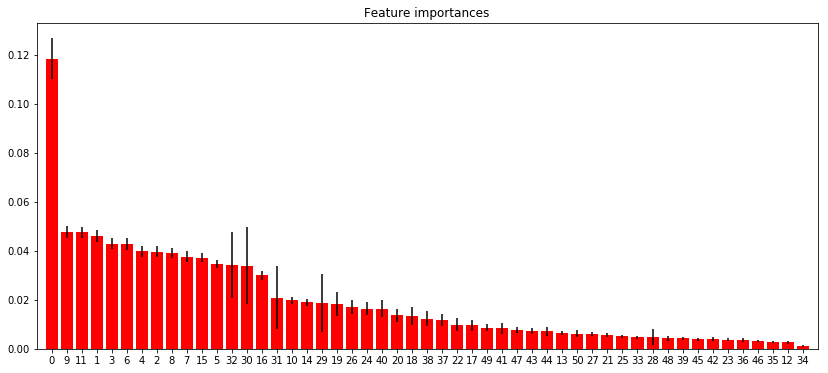

In [73]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}. feature {} {} {:.2f}".format(f + 1, indices[f], df_comb.columns[indices[f]], importances[indices[f]]*100))

# Plot the feature importances of the forest
plt.figure(figsize=(14,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.savefig('feature_importance_rf_18f.png', bbox_inches='tight')
plt.show()

In [74]:
for important_index in indices[0:5]:
    
    # 1:-1 because the first and last columns are not in X
    column_name = X_cols[important_index]
    cas_data = df_comb.loc[df_comb['Y'] == 1][column_name]
    non_cas_data = df_comb.loc[df_comb['Y'] == 0][column_name]
    
    cas_mean, cas_std = np.mean(cas_data), np.std(cas_data)
    non_cas_mean, non_cas_std = np.mean(non_cas_data), np.std(non_cas_data)
    
    cas_median, non_cas_median = np.median(cas_data), np.median(non_cas_data)
    
    print("Feature: {}".format(column_name))
    print("CAS Mean: {:.3f} +/- {:.3f} \t Non-CAS Mean: {:.3f} +/- {:.3f}".format(cas_mean, cas_std, non_cas_mean,non_cas_std))
    print("CAS Median: {:.3f} \t\t Non-CAS Median: {:.3f}\n".format(cas_median, non_cas_median))

Feature: TIME
CAS Mean: 13.527 +/- 5.861 	 Non-CAS Mean: 13.431 +/- 5.442
CAS Median: 14.000 		 Non-CAS Median: 14.000

Feature: Minimum Humidity
CAS Mean: 42.677 +/- 15.374 	 Non-CAS Mean: 42.373 +/- 15.138
CAS Median: 40.000 		 Non-CAS Median: 40.000

Feature: Sea Level Pressure
CAS Mean: 1017.235 +/- 7.348 	 Non-CAS Mean: 1017.289 +/- 7.407
CAS Median: 1017.000 		 Non-CAS Median: 1017.000

Feature: Average Humidity
CAS Mean: 59.499 +/- 14.279 	 Non-CAS Mean: 59.042 +/- 14.162
CAS Median: 58.000 		 Non-CAS Median: 58.000

Feature: Max Gust Speed
CAS Mean: 36.520 +/- 11.140 	 Non-CAS Mean: 36.645 +/- 11.085
CAS Median: 35.000 		 Non-CAS Median: 35.000



### Try modelling with important features

In [75]:
imp_feat_df = df_comb.iloc[:,indices[:15]] 
imp_feat_df.head()

,TIME,Minimum Humidity,Sea Level Pressure,Average Humidity,Max Gust Speed,Maximum Humidity,Max Temperature,Dew Point,Min Temperature,Mean Temperature,Wind Speed,Max Wind Speed,VTC2_two_wheeler,VTC2_other,Month
0,10,89,1014.0,95,34.0,100,8,6,5,7,9.0,23.0,0,1,3
1,10,89,1014.0,95,34.0,100,8,6,5,7,9.0,23.0,0,0,3
2,10,89,1014.0,95,34.0,100,8,6,5,7,9.0,23.0,0,0,3
3,10,89,1014.0,95,34.0,100,8,6,5,7,9.0,23.0,0,0,3
4,11,89,1014.0,95,34.0,100,8,6,5,7,9.0,23.0,0,1,3


In [76]:
# Selecting X and y

y_cols = 'Y'

X, y = imp_feat_df.values, df_comb[y_cols].values 
y = y.astype(int) 

In [77]:
# Defining the model
forest = RandomForestClassifier(criterion='gini', random_state=0, n_estimators=500, n_jobs=-1)

In [78]:
# Evaluating performance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [79]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [80]:
y_pred = forest.predict(X_test)

In [81]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred=y_pred, y_true=y_test)

0.57184348527632112

To do:

- One-hot encoding for time? Since it is so important in the predictions.
- Include contributing factors (inattention DUI, etc). Probably good to threshold here at some limit when doing the one-hot encoding, as we end up with a lot of columns otherwise.
- Check out the encoding for vehicles - should me small, medium, large and two wheeler. This seems to worsen performance, we go from ~65% to ~59% accuracy by categorizing the vehicles this way.